In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

%matplotlib inline

In [2]:
full_df = pd.read_csv('data/full_data_index.csv', index_col=0)
full_df = full_df.loc[2008:]

In [3]:
full_df.head()

,house_prices,tourism,gdp,C,I,earnings_single,earnings_couple,fbcf,construction,alojamento_local,golden_visas,juro,log_juro,log_alojamento_local,log_house_prices
2008,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
2009,96.740822,99.245719,95.631529,97.161779,90.439771,100.857247,101.133837,90.439771,90.705128,197.702298,100.0,109.594664,105.785431,108.966074,99.294023
2010,98.635906,102.772321,97.435897,99.432356,88.814532,105.857362,105.681813,88.814532,87.286325,288.911089,100.0,52.608175,59.440783,113.956360,99.707362
2011,96.539412,99.593038,97.245964,97.918638,83.173996,102.285664,100.356478,83.173996,82.905983,377.822178,100.0,51.975372,58.676608,117.485801,99.249618
2012,88.656962,95.135432,94.112061,92.526017,70.841300,108.229557,105.998705,70.841300,70.726496,475.324675,200.0,80.263383,86.116716,120.505762,97.434819


In [4]:
def create_plot(data, column_names, title='', ylabel='Índice, 2008=100'):
    _data = data.copy()
    _data.columns = column_names

    ax = _data.plot()
    ax.set(title=title, xlabel='Ano', ylabel=ylabel)

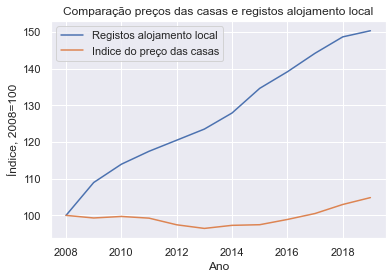

In [5]:
data         = full_df[['log_alojamento_local', 'log_house_prices']]
title        = 'Comparação preços das casas e registos alojamento local'
column_names = ['Registos alojamento local', 'Indice do preço das casas']

create_plot(data, column_names, title)

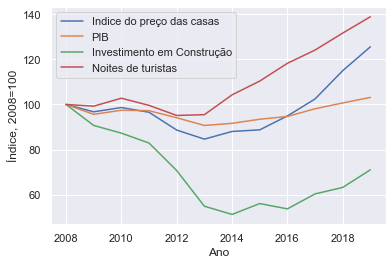

In [6]:
data         = full_df[['house_prices', 'gdp', 'construction', 'tourism']]
title        = ''
column_names = [
    'Indice do preço das casas',
    'PIB',
    'Investimento em Construção',
    'Noites de turistas'
]


create_plot(data, column_names, title)

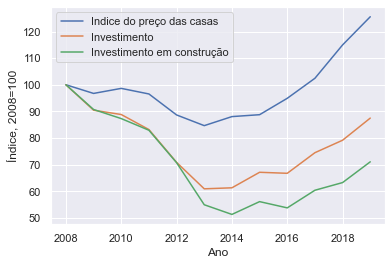

In [7]:
data         = full_df[['house_prices', 'fbcf', 'construction']]
title        = ''
column_names = [
    'Indice do preço das casas',
    'Investimento',
    'Investimento em construção',
]


create_plot(data, column_names, title)

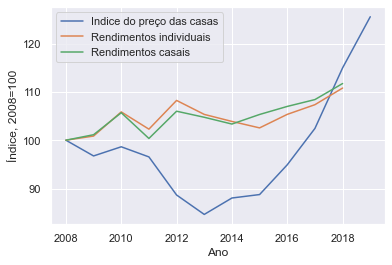

In [8]:
data         = full_df[['house_prices', 'earnings_single',  'earnings_couple']]
title        = ''
column_names = [
    'Indice do preço das casas',
    'Rendimentos individuais',
    'Rendimentos casais',
]


create_plot(data, column_names, title)

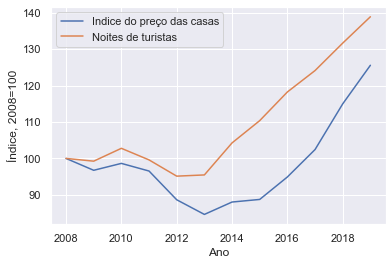

In [9]:
data         = full_df[['house_prices', 'tourism']]
title        = ''
column_names = ['Indice do preço das casas', 'Noites de turistas']


create_plot(data, column_names, title)

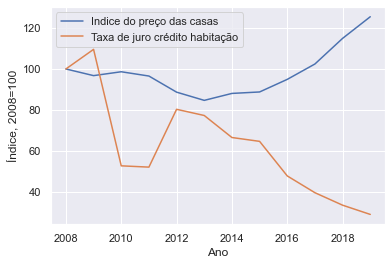

In [10]:
data         = full_df[['house_prices', 'juro']]
title        = ''
column_names = ['Indice do preço das casas', 'Taxa de juro crédito habitação']


create_plot(data, column_names, title)

## Previsão usando ARMA

In [11]:
def train_test_split(df, test_size, columns):
    train_endog = df['house_prices'].loc[2008:2019 - test_size].values
    train_exog = df[columns].loc[2008:2019 - test_size].values

    test_endog = df['house_prices'].loc[2019 - test_size + 1:2019].values
    test_exog = df[columns].loc[2019 - test_size + 1:2019].values

    return train_endog, train_exog, test_endog, test_exog

In [12]:
def make_prediction(order, history_endog, history_exog, obs_exog):
    model = ARIMA(
        history_endog,
        order=order,
        exog=history_exog,
        missing='drop'
    )

    model_fit = model.fit(disp=0)
    output = model_fit.forecast(exog=obs_exog)

    return output[0][0], model_fit

In [13]:
def make_arima(
    df,
    order,
    test_size,
    columns=['construction', 'tourism', 'alojamento_local', 'log_juro'],
    forward_predictions=[]
):
    train_endog, train_exog, test_endog, test_exog = train_test_split(df, test_size, columns)
    
    history_endog = [x for x in train_endog]
    history_exog = [x for x in train_exog]
    predictions = []

    for obs_endog, obs_exog in zip(test_endog, test_exog):
        yhat, model_fit = make_prediction(order, history_endog, history_exog, obs_exog)
        
        history_endog.append(obs_endog)
        history_exog.append(obs_exog)
        predictions.append(yhat)

    error = mean_squared_error(test_endog, predictions)
    print('Test MSE: %.3f' % error)

    dates = list(df.index)
    real = list(train_endog) + list(test_endog)
    predicted = list(train_endog) + predictions
    
    for index, obs_exog in enumerate(forward_predictions):
        yhat, model_fit = make_prediction(order, history_endog, history_exog, obs_exog)

        dates.append(2020 + index)
        history_endog.append(yhat)
        history_exog.append(obs_exog)
        real.append(np.nan)
        predicted.append(yhat)        
            
    return model_fit, dates, real, predicted

In [14]:
def plot_arima(dates, real, predicted):
    print('Último valor previsto: ', str(round(predicted[-1] * 100, 2)) + '%')

    data         = pd.DataFrame(data=list(map(list, zip(*[real, predicted]))),
                                index=dates,
                                columns=['real', 'predicted'])
    title        = 'Previsão da evolução do preço das casas'
    column_names = ['Índice preço das casas - valores reais', 'Índice preço das casas - valores previstos']


    create_plot(data, column_names, title, ylabel='Crescimento percentual')

## Testes ao modelo

In [15]:
columns = ['construction', 'tourism', 'alojamento_local', 'juro']

In [16]:
model_fit, dates, real, predicted = make_arima(
    full_df.pct_change(),
    order=(0,0,1),
    test_size=2,
    columns = columns
)

Test MSE: 0.004


Último valor previsto:  7.69%


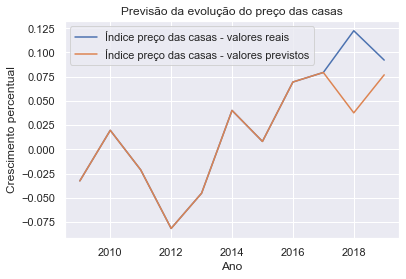

In [17]:
plot_arima(dates, real, predicted)

## Previsões do futuro

In [18]:
base_df = pd.read_csv('data/full_data.csv', index_col=0)

In [19]:
CHANGE_IN_CONSTRUCTION     = -0.24       
CHANGE_IN_TOURISM          = -0.20       # 1.726.977 dormidas
CHANGE_IN_ALOJAMENTO_LOCAL = -0.20       # 73636 Registos de alojamento
CHANGE_IN_JURO             = 0.30        # 1.83%

In [20]:
last_exog = [round(x, 3) for x in full_df.pct_change().loc[2019][columns].values]

forward_predictions = [
    CHANGE_IN_CONSTRUCTION,
    CHANGE_IN_TOURISM,
    CHANGE_IN_ALOJAMENTO_LOCAL,
    CHANGE_IN_JURO,
]

print('Evolução percentual das variáveis exogenas (previsão)')
pd.DataFrame(
    [last_exog, forward_predictions],
    index=[2019, 2020],
    columns=columns
)

Evolução percentual das variáveis exogenas (previsão)


,construction,tourism,alojamento_local,juro
2019,0.123,0.055,0.136,-0.135
2020,-0.240,-0.200,-0.200,0.300


In [21]:
print('Evolução em valor absoluto')

last_data = [round(x, 3) for x in base_df.loc[2019][columns]]
forward_values = [last_data[i] * (1+x) for i, x in enumerate(forward_predictions)]
pd.DataFrame(
    [last_data, forward_values],
    index=[2019, 2020],
    columns=columns
)

Evolução em valor absoluto


,construction,tourism,alojamento_local,juro
2019,66.50,2.158722e+06,92045.0,1.4050
2020,50.54,1.726978e+06,73636.0,1.8265


In [22]:
model_fit, dates, real, predicted = make_arima(
    full_df.pct_change(),
    order=(0,0,1),
    test_size=4,
    forward_predictions=[forward_predictions],
    columns=columns
)

Test MSE: 0.003


Último valor previsto:  -14.43%


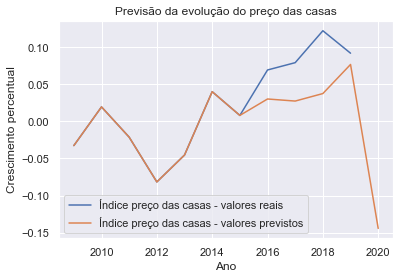

In [23]:
plot_arima(dates, real, predicted)